In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.formula.api as smf

from matplotlib import pyplot as plt

# Import data

In [3]:
df = pd.ExcelFile(r'../Data/raw_data/elife-65722-supp1-v2.xlsx')

## Basic metadata clean up and data subsetting

In [4]:
meta_df = df.parse('Supplementary File 1a', header=1)
print(meta_df.shape)
meta_df.head()

(42, 11)


,Sample,Nitrogen source,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),limiting nutrient,C/N ratio,experiment subset,total RNA content (g/gDW),total protein content (g/gDW),extra notes
0,1,NH4,0.05,7.5,0.5,N,30,GR,0.021734,0.272515,NaN
1,2,NH4,0.05,7.5,0.5,N,30,GR,0.024941,0.250820,NaN
2,3,NH4,0.05,7.5,0.5,N,30,GR,0.025831,0.261097,NaN
3,4,NH4,0.10,7.5,5.0,C,3,NM,0.053444,0.359674,NaN
4,5,NH4,0.10,7.5,5.0,C,3,NM,0.050594,0.377943,NaN


***Check distribution of variables to determine if there are any outliers***

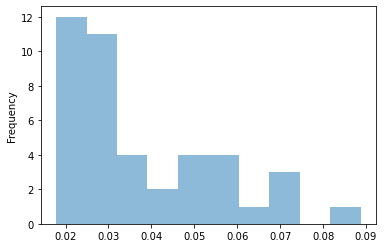

In [5]:
meta_df['total RNA content (g/gDW)'].plot.hist(alpha=0.5)

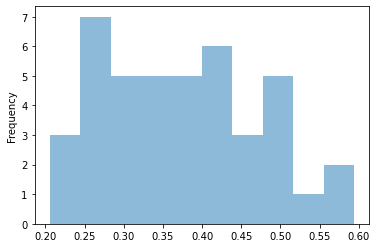

In [6]:
meta_df['total protein content (g/gDW)'].plot.hist(alpha=0.5)

In [7]:
#Change Sample names so that replicates are distinguished
count = 1
for i in range(1, len(meta_df)):
    if meta_df['dilution rate (/h)'][i] == meta_df['dilution rate (/h)'][i-1] and meta_df['glucose.H2O concentration (g/L)'][i] == meta_df['glucose.H2O concentration (g/L)'][i-1] and meta_df['nitrogen source concentration (g/L)'][i] == meta_df['nitrogen source concentration (g/L)'][i-1]:
        meta_df['Sample'][i] = count
    else:
        count+=1
        meta_df['Sample'][i] = count
meta_df.head()

/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sample,Nitrogen source,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),limiting nutrient,C/N ratio,experiment subset,total RNA content (g/gDW),total protein content (g/gDW),extra notes
0,1,NH4,0.05,7.5,0.5,N,30,GR,0.021734,0.272515,NaN
1,1,NH4,0.05,7.5,0.5,N,30,GR,0.024941,0.250820,NaN
2,1,NH4,0.05,7.5,0.5,N,30,GR,0.025831,0.261097,NaN
3,2,NH4,0.10,7.5,5.0,C,3,NM,0.053444,0.359674,NaN
4,2,NH4,0.10,7.5,5.0,C,3,NM,0.050594,0.377943,NaN


## And the same for the expression data

In [8]:
exp_df = df.parse('Supplementary File 1b', header=1, index_col='Gene')
print(exp_df.shape)
drop_cols_lst = []
for col in exp_df.columns:
    if 'RNA' not in col:
        drop_cols_lst.append(col)
exp_df = exp_df.drop(columns=drop_cols_lst)
exp_df.columns = meta_df['Sample']
print(exp_df.shape)
assert list(meta_df['Sample']) == list(exp_df.columns)
exp_df.head()

(3127, 94)
(3127, 42)


Sample,1,1,1,2,2,2,3,3,3,4,...,11,12,12,12,13,13,13,14,14,14
Gene,,,,,,,,,,,,,,,,,,,,,
SAL1,0.072282,0.067356,0.082777,0.176688,0.171669,0.160446,0.084199,0.097253,0.101737,0.106322,...,0.072131,0.095419,0.088348,0.100531,0.115670,0.132605,0.116371,0.090390,0.079206,0.096258
CET1,0.096743,0.098314,0.125094,0.256023,0.231470,0.216784,0.107019,0.136203,0.132498,0.151206,...,0.070266,0.104796,0.106457,0.108522,0.128737,0.156104,0.146589,0.117606,0.098678,0.115185
FOB1,0.073343,0.052760,0.099514,0.198647,0.202158,0.169469,0.092918,0.101562,0.107132,0.114579,...,0.050189,0.088784,0.093748,0.080661,0.122778,0.143516,0.118104,0.101547,0.069630,0.092075
RPS9A,0.441493,0.141326,0.519423,1.290146,1.277890,1.112097,0.549135,0.640281,0.721417,0.784386,...,0.283393,0.469903,0.527683,0.487347,0.790001,0.884259,0.716994,0.687012,0.389067,0.616458
COQ4,0.177795,0.378482,0.237217,0.501951,0.429489,0.436682,0.170530,0.206947,0.220046,0.188816,...,0.146292,0.178524,0.178324,0.182290,0.194778,0.239090,0.247052,0.172873,0.206854,0.186202


In [9]:
###Check if duplicates in Gene column
print(len(exp_df.index.unique()) ==  len(exp_df.index))

True


# Averaging between replicates to clean up the data

## First getting gene expression averages between replicates and creating a new `dataframe`

In [10]:
unique_cols = set(exp_df.columns)
new_exp_df = pd.DataFrame()

for i in unique_cols:
    new_exp_df[i] = exp_df[[col for col in exp_df.columns if col==i]].mean(axis=1)
print(new_exp_df.shape)
new_exp_df.head()

(3127, 14)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Gene,,,,,,,,,,,,,,
SAL1,0.074138,0.169601,0.094396,0.097965,0.167621,0.190164,0.309620,0.231462,0.171209,0.084162,0.076046,0.094766,0.121549,0.088618
CET1,0.106717,0.234759,0.125240,0.134851,0.194820,0.215310,0.320845,0.316977,0.233847,0.102539,0.077529,0.106591,0.143810,0.110490
FOB1,0.075205,0.190091,0.100537,0.108804,0.180068,0.230941,0.383661,0.242665,0.169157,0.077682,0.061528,0.087731,0.128133,0.087751
RPS9A,0.367414,1.226711,0.636944,0.739861,1.208572,1.707511,2.809044,1.602298,0.999183,0.491945,0.387551,0.494978,0.797085,0.564179
COQ4,0.264498,0.456041,0.199175,0.180648,0.234257,0.208554,0.309261,0.594568,0.500712,0.171190,0.156491,0.179712,0.226973,0.188643


**Double checking the work**

Just making sure somethings add up here

In [11]:
for i in unique_cols:
    if len([col for col in exp_df.columns if col==i]) > 1:
        print(i)
        break

1


In [12]:
exp_df[[col for col in exp_df.columns.unique() if col==i]].head()

Sample,1,1,1
Gene,,,
SAL1,0.072282,0.067356,0.082777
CET1,0.096743,0.098314,0.125094
FOB1,0.073343,0.052760,0.099514
RPS9A,0.441493,0.141326,0.519423
COQ4,0.177795,0.378482,0.237217


In [13]:
new_exp_df[[i]].head()

,1
Gene,
SAL1,0.074138
CET1,0.106717
FOB1,0.075205
RPS9A,0.367414
COQ4,0.264498


### Get correlation between conditions

In [14]:
temp_corr = new_exp_df.corr(method='spearman')

In [15]:
temp_df = pd.DataFrame(
    np.where(np.equal(*np.indices(temp_corr.shape)), np.nan, temp_corr.values),
    temp_corr.index, temp_corr.columns
)
print(temp_df.shape)
temp_df.head()

(14, 14)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,NaN,0.943940,0.956269,0.934834,0.900581,0.809568,0.776444,0.926069,0.930175,0.962432,0.909313,0.944553,0.934147,0.958375
2,0.943940,NaN,0.943136,0.935752,0.927566,0.880579,0.861945,0.990825,0.978096,0.937910,0.953740,0.944168,0.958125,0.946687
3,0.956269,0.943136,NaN,0.993834,0.975947,0.913042,0.887494,0.927089,0.934762,0.994826,0.924387,0.978675,0.967283,0.991202
4,0.934834,0.935752,0.993834,NaN,0.991091,0.937332,0.913159,0.922725,0.927419,0.988105,0.928374,0.978320,0.964377,0.984507
5,0.900581,0.927566,0.975947,0.991091,NaN,0.968057,0.948385,0.919228,0.919488,0.967053,0.931872,0.969483,0.959971,0.968292


In [16]:
#Make sure there are no duplicate rows
temp_df[temp_df.values==1]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14


In [17]:
print(new_exp_df.shape)

(3127, 14)


## Average the growth rates across these replicates in the metadata as well

In [18]:
meta_df.head()

,Sample,Nitrogen source,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),limiting nutrient,C/N ratio,experiment subset,total RNA content (g/gDW),total protein content (g/gDW),extra notes
0,1,NH4,0.05,7.5,0.5,N,30,GR,0.021734,0.272515,NaN
1,1,NH4,0.05,7.5,0.5,N,30,GR,0.024941,0.250820,NaN
2,1,NH4,0.05,7.5,0.5,N,30,GR,0.025831,0.261097,NaN
3,2,NH4,0.10,7.5,5.0,C,3,NM,0.053444,0.359674,NaN
4,2,NH4,0.10,7.5,5.0,C,3,NM,0.050594,0.377943,NaN


In [19]:
#Keep columns that are strings
string_col_lst = ['Sample', 'extra notes']

for col in meta_df.columns:
    if type(meta_df[col].tolist()[0]) == str:
        string_col_lst.append(col)

str_df = meta_df[string_col_lst]
str_df = str_df.drop_duplicates()
str_df.head()

,Sample,extra notes,Nitrogen source,limiting nutrient,experiment subset
0,1,NaN,NH4,N,GR
3,2,NaN,NH4,C,NM
6,3,NaN,NH4,N,"GR, NM"
9,4,NaN,NH4,N,GR
12,5,NaN,NH4,N,GR


In [20]:
meta_df['Doubling_time'] = np.log(2)/meta_df['dilution rate (/h)']
meta_df = meta_df.groupby('Sample').mean().reset_index()
meta_df = meta_df.merge(str_df, on='Sample', how='left')
meta_df.head()

,Sample,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),C/N ratio,total RNA content (g/gDW),total protein content (g/gDW),Doubling_time,extra notes,Nitrogen source,limiting nutrient,experiment subset
0,1,0.05,7.5,0.5,30,0.024169,0.261477,13.862944,NaN,NH4,N,GR
1,2,0.10,7.5,5.0,3,0.050000,0.358024,6.931472,NaN,NH4,C,NM
2,3,0.10,7.5,0.5,30,0.025297,0.225573,6.931472,NaN,NH4,N,"GR, NM"
3,4,0.13,7.5,0.5,30,0.025831,0.275686,5.331901,NaN,NH4,N,GR
4,5,0.18,7.5,0.5,30,0.038539,0.286470,3.850818,NaN,NH4,N,GR


# Construct a third `dataframe` containing expression data summary stats

In [21]:
exp_summary_df = new_exp_df.apply(pd.DataFrame.describe, axis=1)

In [22]:
col_listy = []
for col in exp_summary_df.columns:
    if '%' not in col:
        col_listy.append(col)
    else:
        col_listy.append(col.replace('%', '_percentile'))
print(col_listy)
exp_summary_df.columns = col_listy

['count', 'mean', 'std', 'min', '25_percentile', '50_percentile', '75_percentile', 'max']


In [23]:
exp_summary_df['cv'] = exp_summary_df['std']/exp_summary_df['mean']
exp_summary_df['noise'] = exp_summary_df['std'].pow(2)/exp_summary_df['mean'].pow(2)

In [24]:
slopes = []
pearsons = []
spearmans = []
for gene in exp_summary_df.index:
    a, b, c, d, e = stats.linregress(new_exp_df.loc[gene], meta_df['dilution rate (/h)'])
    slopes.append(a)
    pearsons.append(c)
    rho, p = stats.spearmanr(new_exp_df.loc[gene], meta_df['dilution rate (/h)'])
    spearmans.append(rho)
    
exp_summary_df['lin_slope'] = slopes
exp_summary_df['lin_r'] = pearsons
exp_summary_df['spearmans_rho'] = spearmans

In [25]:
exp_summary_df

,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
Gene,,,,,,,,,,,,,
SAL1,14.0,0.140808,0.069435,0.074138,0.090062,0.109757,0.170807,0.309620,0.493117,0.243164,0.897751,0.734153,0.627535
CET1,14.0,0.173166,0.080264,0.077529,0.107660,0.139330,0.229212,0.320845,0.463506,0.214838,0.588112,0.555943,0.478976
FOB1,14.0,0.151711,0.089270,0.061528,0.087736,0.118468,0.187586,0.383661,0.588421,0.346239,0.759085,0.798082,0.632658
RPS9A,14.0,1.002377,0.676519,0.367414,0.512278,0.768473,1.222176,2.809044,0.674915,0.455511,0.106400,0.847764,0.694131
COQ4,14.0,0.276480,0.139088,0.156491,0.182647,0.217764,0.298070,0.594568,0.503066,0.253076,-0.043913,-0.071934,0.017930
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HRP1,14.0,0.643431,0.343658,0.278390,0.403263,0.492690,0.761781,1.529286,0.534102,0.285265,0.191346,0.774459,0.586553
VCX1,14.0,0.563477,0.206097,0.319568,0.422873,0.486362,0.690812,0.993312,0.365760,0.133780,0.090445,0.219539,0.263821
TRS33,14.0,0.377113,0.218707,0.153415,0.214095,0.290779,0.497381,0.947195,0.579950,0.336341,0.319587,0.823196,0.642903


# Save some files

In [25]:
# print(new_exp_df.shape)
# print(meta_df.shape)
# print(exp_summary_df.shape)
# new_exp_df.to_csv('../Data/processed_data/processed_expression_yeast.tsv', sep='\t')
# meta_df.to_csv('../Data/processed_data/processed_metadata_yeast.tsv', sep='\t')
# exp_summary_df.to_csv('../Data/processed_data/processed_expression_summary_yeast.tsv', sep='\t')

(3127, 14)
(14, 12)
(3127, 13)


In [26]:
new_exp_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Gene,,,,,,,,,,,,,,
SAL1,0.074138,0.169601,0.094396,0.097965,0.167621,0.190164,0.309620,0.231462,0.171209,0.084162,0.076046,0.094766,0.121549,0.088618
CET1,0.106717,0.234759,0.125240,0.134851,0.194820,0.215310,0.320845,0.316977,0.233847,0.102539,0.077529,0.106591,0.143810,0.110490
FOB1,0.075205,0.190091,0.100537,0.108804,0.180068,0.230941,0.383661,0.242665,0.169157,0.077682,0.061528,0.087731,0.128133,0.087751
RPS9A,0.367414,1.226711,0.636944,0.739861,1.208572,1.707511,2.809044,1.602298,0.999183,0.491945,0.387551,0.494978,0.797085,0.564179
COQ4,0.264498,0.456041,0.199175,0.180648,0.234257,0.208554,0.309261,0.594568,0.500712,0.171190,0.156491,0.179712,0.226973,0.188643


In [27]:
meta_df.head()

,Sample,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),C/N ratio,total RNA content (g/gDW),total protein content (g/gDW),Doubling_time,extra notes,Nitrogen source,limiting nutrient,experiment subset
0,1,0.05,7.5,0.5,30,0.024169,0.261477,13.862944,NaN,NH4,N,GR
1,2,0.10,7.5,5.0,3,0.050000,0.358024,6.931472,NaN,NH4,C,NM
2,3,0.10,7.5,0.5,30,0.025297,0.225573,6.931472,NaN,NH4,N,"GR, NM"
3,4,0.13,7.5,0.5,30,0.025831,0.275686,5.331901,NaN,NH4,N,GR
4,5,0.18,7.5,0.5,30,0.038539,0.286470,3.850818,NaN,NH4,N,GR


In [28]:
exp_summary_df.head()

,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
Gene,,,,,,,,,,,,,
SAL1,14.0,0.140808,0.069435,0.074138,0.090062,0.109757,0.170807,0.309620,0.493117,0.243164,0.897751,0.734153,0.627535
CET1,14.0,0.173166,0.080264,0.077529,0.107660,0.139330,0.229212,0.320845,0.463506,0.214838,0.588112,0.555943,0.478976
FOB1,14.0,0.151711,0.089270,0.061528,0.087736,0.118468,0.187586,0.383661,0.588421,0.346239,0.759085,0.798082,0.632658
RPS9A,14.0,1.002377,0.676519,0.367414,0.512278,0.768473,1.222176,2.809044,0.674915,0.455511,0.106400,0.847764,0.694131
COQ4,14.0,0.276480,0.139088,0.156491,0.182647,0.217764,0.298070,0.594568,0.503066,0.253076,-0.043913,-0.071934,0.017930


<AxesSubplot:ylabel='Frequency'>

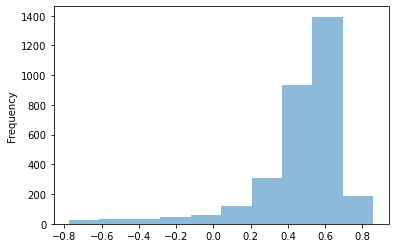

In [29]:
exp_summary_df['spearmans_rho'].plot.hist(alpha=0.5)

LinregressResult(slope=-0.024540309379953804, intercept=0.48428289852259354, rvalue=-0.07767619674207239, pvalue=1.370999446692013e-05, stderr=0.005634468086592845)


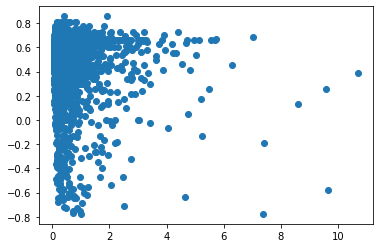

In [32]:
fig, ax = plt.subplots()
ax.scatter(exp_summary_df['mean'], exp_summary_df['spearmans_rho'])
print(stats.linregress(exp_summary_df['mean'], exp_summary_df['spearmans_rho']))

# Get a thinned down set as a robustness check

Since conditions are correlated with one another, I'm constructing a more sparsely populated dataset where inter-condition correlations are minimized using a greedy algorithm. 

The algorithm works as follows:
1. Find which two conditions are the most highly correlated across the entire all-to-all correlation matrix
2. Randomly delete one of the two conditions in question
3. Iterate to (1)
4. Stop after reaching a pre-defined final dataset size

In [33]:
import random

In [34]:
cond_corr_mat = new_exp_df.corr(method='spearman')
cond_corr_mat.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,1.000000,0.943940,0.956269,0.934834,0.900581,0.809568,0.776444,0.926069,0.930175,0.962432,0.909313,0.944553,0.934147,0.958375
2,0.943940,1.000000,0.943136,0.935752,0.927566,0.880579,0.861945,0.990825,0.978096,0.937910,0.953740,0.944168,0.958125,0.946687
3,0.956269,0.943136,1.000000,0.993834,0.975947,0.913042,0.887494,0.927089,0.934762,0.994826,0.924387,0.978675,0.967283,0.991202
4,0.934834,0.935752,0.993834,1.000000,0.991091,0.937332,0.913159,0.922725,0.927419,0.988105,0.928374,0.978320,0.964377,0.984507
5,0.900581,0.927566,0.975947,0.991091,1.000000,0.968057,0.948385,0.919228,0.919488,0.967053,0.931872,0.969483,0.959971,0.968292


In [35]:
final_data_size = 10
n_to_prune = cond_corr_mat.shape[1] - final_data_size

In [36]:
np.fill_diagonal(cond_corr_mat.values, np.nan)
to_prune = []
for i in range(n_to_prune):
    tempy = cond_corr_mat.loc[[i for i in cond_corr_mat.columns if i not in to_prune]][[i for i in cond_corr_mat.columns if i not in to_prune]].max()
    to_prune.append(random.choice([tempy.sort_values(ascending=False).index[0],\
                                   tempy.sort_values(ascending=False).index[1]]))
np.fill_diagonal(cond_corr_mat.values, 1.)

In [37]:
to_keep = [i for i in cond_corr_mat.columns if i not in to_prune]
new_exp_df = new_exp_df[to_keep]
meta_df = meta_df[meta_df['Sample'].isin(to_keep)]

In [38]:
exp_summary_df = new_exp_df.apply(pd.DataFrame.describe, axis=1)
col_listy = []
for col in exp_summary_df.columns:
    if '%' not in col:
        col_listy.append(col)
    else:
        col_listy.append(col.replace('%', '_percentile'))
print(col_listy)
exp_summary_df.columns = col_listy

exp_summary_df['cv'] = exp_summary_df['std']/exp_summary_df['mean']
exp_summary_df['noise'] = exp_summary_df['std'].pow(2)/exp_summary_df['mean'].pow(2)

slopes = []
pearsons = []
spearmans = []
for gene in exp_summary_df.index:
    a, b, c, d, e = stats.linregress(new_exp_df.loc[gene], meta_df['dilution rate (/h)'])
    slopes.append(a)
    pearsons.append(c)
    rho, p = stats.spearmanr(new_exp_df.loc[gene], meta_df['dilution rate (/h)'])
    spearmans.append(rho)
    
exp_summary_df['lin_slope'] = slopes
exp_summary_df['lin_r'] = pearsons
exp_summary_df['spearmans_rho'] = spearmans

['count', 'mean', 'std', 'min', '25_percentile', '50_percentile', '75_percentile', 'max']


In [39]:
print(new_exp_df.shape)
print(meta_df.shape)
print(exp_summary_df.shape)
new_exp_df.to_csv('../Data/processed_data/processed_expression_SPARSE_yeast.tsv', sep='\t')
meta_df.to_csv('../Data/processed_data/processed_metadata_SPARSE_yeast.tsv', sep='\t')
exp_summary_df.to_csv('../Data/processed_data/processed_expression_summary_SPARSE_yeast.tsv', sep='\t')

(3127, 10)
(10, 12)
(3127, 13)


# Scratch

In [40]:
new_exp_df.head()

,1,4,7,8,9,10,11,12,13,14
Gene,,,,,,,,,,
SAL1,0.074138,0.097965,0.309620,0.231462,0.171209,0.084162,0.076046,0.094766,0.121549,0.088618
CET1,0.106717,0.134851,0.320845,0.316977,0.233847,0.102539,0.077529,0.106591,0.143810,0.110490
FOB1,0.075205,0.108804,0.383661,0.242665,0.169157,0.077682,0.061528,0.087731,0.128133,0.087751
RPS9A,0.367414,0.739861,2.809044,1.602298,0.999183,0.491945,0.387551,0.494978,0.797085,0.564179
COQ4,0.264498,0.180648,0.309261,0.594568,0.500712,0.171190,0.156491,0.179712,0.226973,0.188643


In [41]:
meta_df.head()

,Sample,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),C/N ratio,total RNA content (g/gDW),total protein content (g/gDW),Doubling_time,extra notes,Nitrogen source,limiting nutrient,experiment subset
0,1,0.05,7.50,0.50,30,0.024169,0.261477,13.862944,NaN,NH4,N,GR
3,4,0.13,7.50,0.50,30,0.025831,0.275686,5.331901,NaN,NH4,N,GR
6,7,0.35,7.50,0.50,30,0.077494,0.494314,1.980421,NaN,NH4,N,GR
7,8,0.10,7.50,5.53,5,0.064727,0.558604,6.931472,"labeled ""Q"" or ""Gln""",Gln,C,NM
8,9,0.10,1.21,5.53,3,0.054038,0.387712,6.931472,"labeled ""Q*"" or ""Gln*""",Gln,C,NM


In [42]:
exp_summary_df.head()

,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
Gene,,,,,,,,,,,,,
SAL1,10.0,0.134953,0.079018,0.074138,0.085276,0.096366,0.158794,0.309620,0.585523,0.342837,0.811421,0.781309,0.633817
CET1,10.0,0.165420,0.091173,0.077529,0.106623,0.122670,0.211337,0.320845,0.551165,0.303783,0.546352,0.607002,0.454857
FOB1,10.0,0.142232,0.100845,0.061528,0.080195,0.098278,0.158901,0.383661,0.709016,0.502704,0.685109,0.841902,0.574163
RPS9A,10.0,0.925354,0.757694,0.367414,0.492703,0.652020,0.948658,2.809044,0.818815,0.670458,0.095464,0.881423,0.633817
COQ4,10.0,0.277270,0.151610,0.156491,0.179946,0.207808,0.298070,0.594568,0.546795,0.298985,0.027736,0.051242,0.007457


<AxesSubplot:ylabel='Frequency'>

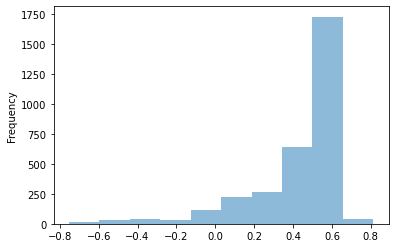

In [43]:
exp_summary_df['spearmans_rho'].plot.hist(alpha=0.5)

LinregressResult(slope=-0.0317056657237392, intercept=0.44479787285328176, rvalue=-0.09869942946824656, pvalue=3.1926046819820405e-08, stderr=0.005718360039051285)


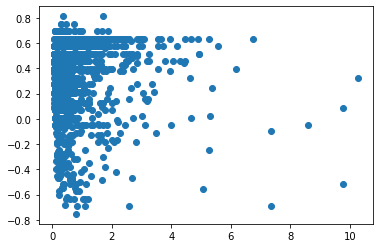

In [45]:
fig, ax = plt.subplots()
ax.scatter(exp_summary_df['mean'], exp_summary_df['spearmans_rho'])
print(stats.linregress(exp_summary_df['mean'], exp_summary_df['spearmans_rho']))